In [1]:
!hostname

n119.clstr


In [3]:
import xarray as xr
import os
import glob
import geopandas as gpd
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import LogNorm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import seaborn as sns
from scipy.stats import linregress


In [4]:
path='/center1/DYNDOWN/phutton5/ROS/All_of_AK/All_of_AK_netcdf_files/'
compare=f'ROS_Monthly_*.nc'
file_list = sorted(glob.glob(os.path.join(path, compare)))
combined_ds=xr.open_mfdataset(file_list, combine='by_coords',engine='netcdf4')

os.chdir("/import/beegfs/CMIP6/wrf_era5")
geo_em_path = "geo_em.d02.nc"
geo = xr.open_dataset(geo_em_path)
oceanmask=geo['LU_INDEX']
oceanmask=oceanmask.squeeze(dim='Time')
#oceanmask_expanded = oceanmask.expand_dims(Time=data.Time)

combined_ds = combined_ds.where(oceanmask != 17)

lat=combined_ds['XLAT']
lon=combined_ds['XLONG']
monthlist=['November','December','January','February','March' ]
monthnumberlist=[11,12,1,2,3]

In [ ]:
combined_ds

In [5]:
shapefile_path = "/center1/DYNDOWN/phutton5/ROS/boundaries/Alaska_Borough_and_Census_Area_Boundaries.shp"
borough_boundaries = gpd.read_file(shapefile_path)
borough_boundaries = borough_boundaries.set_crs(epsg=3338)
borough_boundaries = borough_boundaries.to_crs(epsg=4326)
FNSB_boundary = borough_boundaries[borough_boundaries['CommunityN'] == 'Fairbanks North Star Borough']
FNSB_geom = FNSB_boundary.geometry.iloc[0] 
FNSB_coords = []
FNSB_coords.extend(list(FNSB_geom.exterior.coords))
FNSB_coords = np.array(FNSB_coords)  
FNSB_coords = pd.DataFrame({
    "lon": FNSB_coords[:, 0],
    "lat": FNSB_coords[:, 1]
})

Fairbanks_lat=(64.84)
Fairbanks_lon=(-147.72)

In [6]:
seasonal_total_ros_tally = combined_ds.ros_tally.sum(dim='month')
print("ROS tally from monthly sum:", seasonal_total_ros_tally)
avg_seasonal_total_ros_tally=np.mean(seasonal_total_ros_tally,axis=0)

ROS tally from monthly sum: <xarray.DataArray 'ros_tally' (season: 73, south_north: 450, west_east: 420)> Size: 110MB
dask.array<sum-aggregate, shape=(73, 450, 420), dtype=float64, chunksize=(1, 450, 420), chunktype=numpy.ndarray>
Coordinates:
  * season   (season) <U9 3kB '1950-1951' '1951-1952' ... '2022-2023'
    XLAT     (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
    XLONG    (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east


In [ ]:
'''

rostally_dict = {}
for monthname, monthnumber in zip(monthlist, monthnumberlist):
    rostally_dict[monthname] = combined_ds['ros_tally'].sel(month=monthnumber).fillna(0)


ros_rain_sum_dict = {}
for monthname, monthnumber in zip(monthlist, monthnumberlist):
    ros_rain_sum_dict[monthname] = combined_ds['rain_ros_sum'].sel(month=monthnumber).fillna(0)
'''

In [8]:
average_1950_2022=np.sum(combined_ds['ros_tally'],axis=(1))
average_1950_2022=np.mean(average_1950_2022,axis=(0))

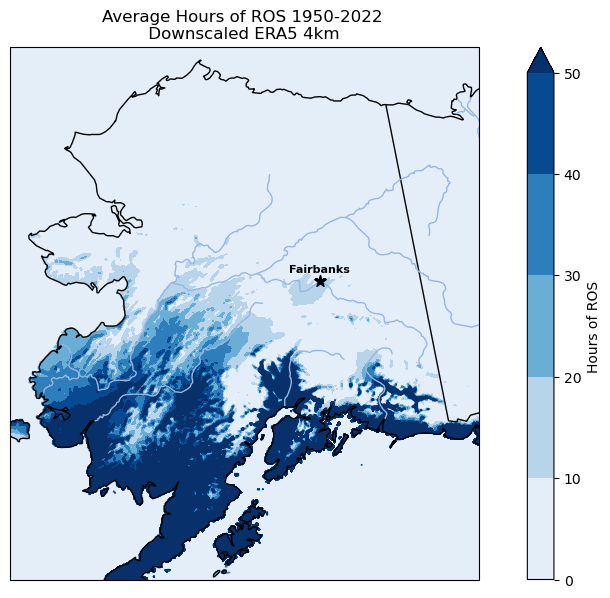

/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/phutton5/miniconda3/envs/dyndown/lib/python3.11/site-packages/dask/core.py:133: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/phutton5/miniconda3/envs

In [9]:
AK_ALBERS_SUBPLOT_KW = {'projection': ccrs.AlbersEqualArea(central_longitude=-154, central_latitude=50,standard_parallels=(55, 65))}
cmap = plt.get_cmap('Blues')
levels=np.arange(0,60,10)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10,6))
cf = ax.contourf(lon, lat,avg_seasonal_total_ros_tally, cmap=cmap,levels=levels, extend='max',transform=ccrs.PlateCarree())
cbar = fig.colorbar(cf, ax=ax, label='Hours of ROS', ticks=np.arange(0, 60, 10) )
cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

#FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=2, transform=ccrs.PlateCarree())
ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', zorder=10, s=75,label='Fairbanks', transform=ccrs.PlateCarree())
ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks',
        transform=ccrs.PlateCarree(), ha='center', va='bottom',
        fontsize=8, zorder=10, fontweight='bold', color='black')
ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hours of ROS 1950-2022 \n Downscaled ERA5 4km ")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show() 

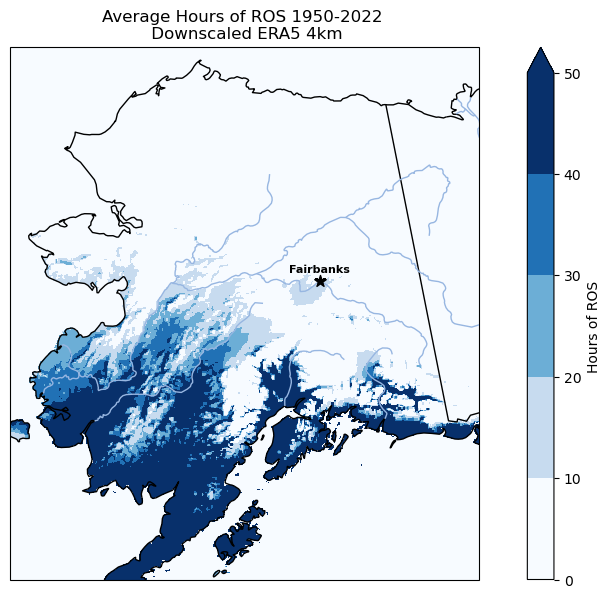

In [10]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))}

cmap = plt.get_cmap('Blues')
levels = np.arange(0, 60, 10)
norm = mcolors.BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots(subplot_kw=AK_ALBERS_SUBPLOT_KW, figsize=(10, 6))

cf = ax.pcolormesh(
    lon,
    lat,
    avg_seasonal_total_ros_tally,
    cmap=cmap,
    norm=norm,
    transform=ccrs.PlateCarree(),
    shading='auto'
)

cbar = fig.colorbar(
    cf,
    ax=ax,
    label='Hours of ROS',
    ticks=np.arange(0, 60, 10),
    extend='max'
)

cbar.ax.set_position([0.77, 0.1, 0.02, 0.8])

ax.scatter(
    Fairbanks_lon,
    Fairbanks_lat,
    marker='*',
    color='k',
    zorder=10,
    s=75,
    label='Fairbanks',
    transform=ccrs.PlateCarree()
)

ax.text(
    Fairbanks_lon,
    Fairbanks_lat + 0.2,
    'Fairbanks',
    transform=ccrs.PlateCarree(),
    ha='center',
    va='bottom',
    fontsize=8,
    zorder=10,
    fontweight='bold',
    color='black'
)

ax.add_feature(cfeature.BORDERS, zorder=9)
ax.add_feature(cfeature.COASTLINE, zorder=9)
ax.add_feature(cfeature.RIVERS, zorder=9)

ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
ax.set_aspect('equal')
ax.set_title("Average Hours of ROS 1950-2022 \n Downscaled ERA5 4km")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

fig.patch.set_alpha(0.0)
plt.tight_layout()
plt.show()


In [11]:
nov_ros_tally_avg=np.mean(rostally_dict['November'],axis=0)
dec_ros_tally_avg=np.mean(rostally_dict['December'],axis=0)
jan_ros_tally_avg=np.mean(rostally_dict['January'],axis=0)
feb_ros_tally_avg=np.mean(rostally_dict['February'],axis=0)
mar_ros_tally_avg=np.mean(rostally_dict['March'],axis=0)

ros_total=combined_ds['ros_tally'].sum(axis=1).mean(axis=0)

nov_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['November'],axis=0)
dec_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['December'],axis=0)
jan_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['January'],axis=0)
feb_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['February'],axis=0)
mar_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['March'],axis=0)

ros_rain_sum_season_total_SUM=combined_ds['rain_ros_sum'].sum(axis=1).mean(axis=0)

In [52]:
nov_ros_tally_avg=np.mean(combined_ds['ros_tally'].sel(month=11),axis=0)
dec_ros_tally_avg=np.mean(combined_ds['ros_tally'].sel(month=12),axis=0)
jan_ros_tally_avg=np.mean(combined_ds['ros_tally'].sel(month=1),axis=0)
feb_ros_tally_avg=np.mean(combined_ds['ros_tally'].sel(month=2),axis=0)
mar_ros_tally_avg=np.mean(combined_ds['ros_tally'].sel(month=3),axis=0)


nov_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=11),axis=0)
dec_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=12),axis=0)
jan_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=1),axis=0)
feb_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=2),axis=0)
mar_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=3),axis=0)

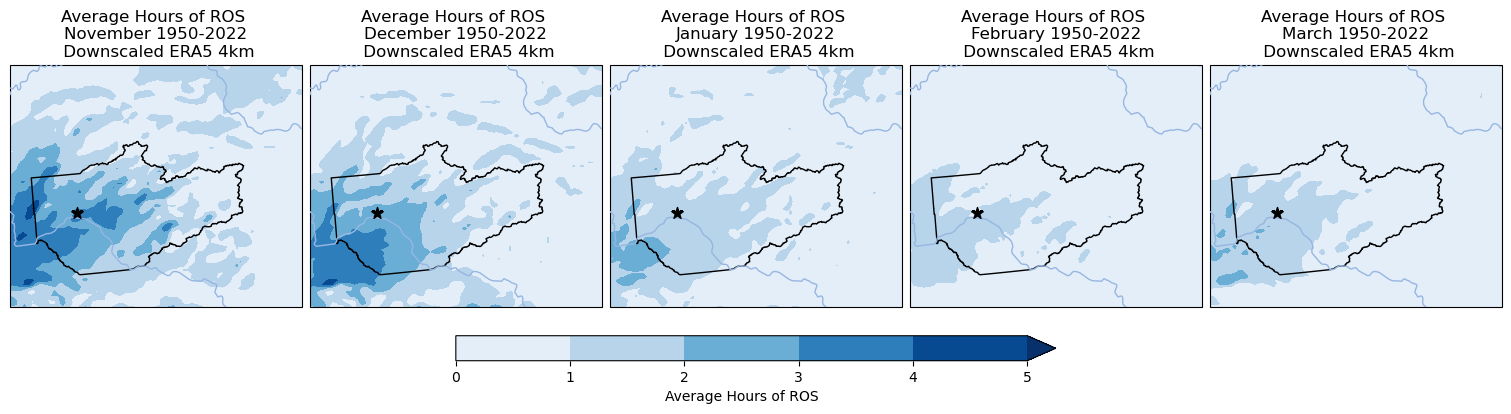

In [53]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15,5), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

#fig.suptitle("Average Days of ROS", y=0.9)
#levels = np.arange(0, 11, 1) 
levels=np.arange(0,6,1)

cf1 = axs[0].contourf(lon, lat, nov_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[0].set_title("Average Hours of ROS \nNovember 1950-2022\n Downscaled ERA5 4km")

cf2 = axs[1].contourf(lon, lat, dec_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[1].set_title("Average Hours of ROS \nDecember 1950-2022\n Downscaled ERA5 4km")

cf3 = axs[2].contourf(lon, lat, jan_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[2].set_title("Average Hours of ROS \nJanuary 1950-2022\n Downscaled ERA5 4km")

cf4 = axs[3].contourf(lon, lat, feb_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[3].set_title("Average Hours of ROS \nFebruary 1950-2022\n Downscaled ERA5 4km")
    
cf5 = axs[4].contourf(lon, lat, mar_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
axs[4].set_title("Average Hours of ROS \nMarch 1950-2022\n Downscaled ERA5 4km")

for ax in axs:
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    #ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
    #        fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8,) 
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.05])
fig.colorbar(cf1, cax=cbar_ax, orientation='horizontal', label='Average Hours of ROS', ticks=levels)

fig.patch.set_alpha(0.0)
plt.show()

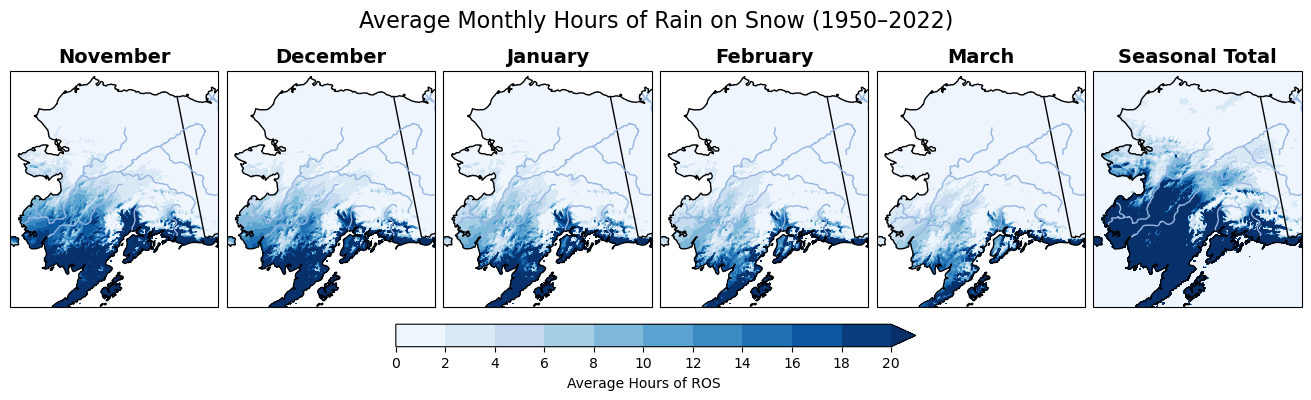

In [54]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(13, 4.5), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)

#fig.suptitle("Average Days of ROS", y=0.9)
#levels = np.arange(0, 11, 1) 
levels=np.arange(0,22,2)

cf1 = axs[0].contourf(lon, lat, nov_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
#axs[0].set_title("November")

cf2 = axs[1].contourf(lon, lat, dec_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
#axs[1].set_title("December")

cf3 = axs[2].contourf(lon, lat, jan_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
#axs[2].set_title("January")

cf4 = axs[3].contourf(lon, lat, feb_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
#axs[3].set_title(" February")
    
cf5 = axs[4].contourf(lon, lat, mar_ros_tally_avg, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
#axs[4].set_title("March")

cf5 = axs[5].contourf(lon, lat, ros_total, levels=levels, cmap='Blues', extend='max', transform=ccrs.PlateCarree())
#axs[5].set_title("Seasonal")

for ax in axs:
    #ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    #ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
    #        fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

titles = ["November", "December", "January", "February", "March", "Seasonal Total"]
for ax, title in zip(axs, titles):
    ax.set_title(title, fontsize=14, fontweight="bold")

fig.suptitle("Average Monthly Hours of Rain on Snow (1950–2022)",fontsize=16, y=0.90)
cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.05])
fig.colorbar(cf1, cax=cbar_ax, orientation='horizontal',boundaries=levels, label='Average Hours of ROS', ticks=levels)

fig.patch.set_alpha(0.0)
plt.show()

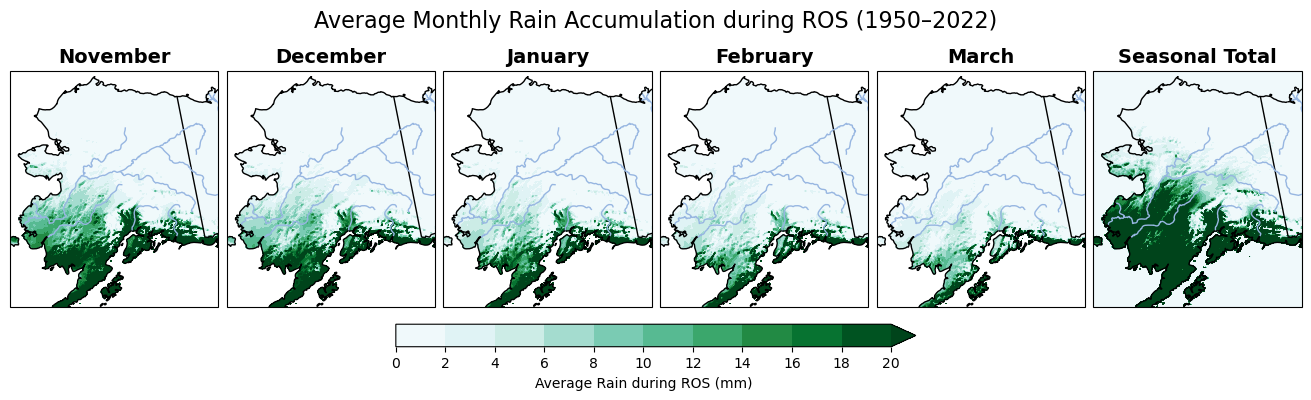

In [55]:
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154, central_latitude=50,
        standard_parallels=(55, 65))}
fig, axs = plt.subplots(nrows=1, ncols=6,figsize=(13, 4.5), subplot_kw=AK_ALBERS_SUBPLOT_KW, constrained_layout=True)
levels=np.arange(0,22,2)

cf1 = axs[0].contourf(lon, lat, nov_ros_rain_sum_avg, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
#axs[0].set_title("Average Rain Accumulation\n during ROS\nNovember 1950-2022\n Downscaled ERA5 4km")

cf2 = axs[1].contourf(lon, lat, dec_ros_rain_sum_avg, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
#axs[1].set_title("Average Rain Accumulation\n during ROS \nDecember 1950-2022\n Downscaled ERA5 4km")

cf3 = axs[2].contourf(lon, lat, jan_ros_rain_sum_avg, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
#axs[2].set_title("Average Rain Accumulation\n during ROS\nJanuary 1950-2022\n Downscaled ERA5 4km")

cf4 = axs[3].contourf(lon, lat, feb_ros_rain_sum_avg, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
#axs[3].set_title("Average Rain Accumulation\n during ROS \nFebruary 1950-2022\n Downscaled ERA5 4km")

cf5 = axs[4].contourf(lon, lat, mar_ros_rain_sum_avg, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
#axs[4].set_title("Average Rain Accumulation\n during ROS\nMarch 1950-2022\n Downscaled ERA5 4km")

cf5 = axs[5].contourf(lon, lat, ros_rain_sum_season_total_SUM, levels=levels, cmap='BuGn', extend='max', transform=ccrs.PlateCarree())
#axs[5].set_title("Average Rain Accumulation\n during ROS\nSeasonal 1950-2022\n Downscaled ERA5 4km")

fig.suptitle("Average Monthly Rain Accumulation during ROS (1950–2022)",fontsize=16, y=0.90)

for ax in axs:
    #ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    #ax.text(Fairbanks_lon, Fairbanks_lat + 0.2, 'Fairbanks', ha='center', va='bottom', fontsize=8,
    #        fontweight='bold', color='black', zorder=6, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

titles = ["November", "December", "January", "February", "March", "Seasonal Total"]
for ax, title in zip(axs, titles):
    ax.set_title(title, fontsize=14, fontweight="bold")

cbar_ax = fig.add_axes([0.3, 0.15, 0.4, 0.05])
fig.colorbar(cf1, cax=cbar_ax, orientation='horizontal', label='Average Rain during ROS (mm)', ticks=levels)

fig.patch.set_alpha(0.0)
plt.show()


Percentage 
-

In [42]:
'''nov_ros_tally_avg=np.mean(rostally_dict['November'],axis=0)
dec_ros_tally_avg=np.mean(rostally_dict['December'],axis=0)
jan_ros_tally_avg=np.mean(rostally_dict['January'],axis=0)
feb_ros_tally_avg=np.mean(rostally_dict['February'],axis=0)
mar_ros_tally_avg=np.mean(rostally_dict['March'],axis=0)

ros_total=combined_ds['ros_tally'].sum(axis=1).mean(axis=0)

nov_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['November'],axis=0)
dec_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['December'],axis=0)
jan_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['January'],axis=0)
feb_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['February'],axis=0)
mar_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['March'],axis=0)

ros_rain_sum_season_total_SUM=combined_ds['rain_ros_sum'].sum(axis=1).mean(axis=0)'''

"nov_ros_tally_avg=np.mean(rostally_dict['November'],axis=0)\ndec_ros_tally_avg=np.mean(rostally_dict['December'],axis=0)\njan_ros_tally_avg=np.mean(rostally_dict['January'],axis=0)\nfeb_ros_tally_avg=np.mean(rostally_dict['February'],axis=0)\nmar_ros_tally_avg=np.mean(rostally_dict['March'],axis=0)\n\nros_total=combined_ds['ros_tally'].sum(axis=1).mean(axis=0)\n\nnov_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['November'],axis=0)\ndec_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['December'],axis=0)\njan_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['January'],axis=0)\nfeb_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['February'],axis=0)\nmar_ros_rain_sum_avg=np.mean(ros_rain_sum_dict['March'],axis=0)\n\nros_rain_sum_season_total_SUM=combined_ds['rain_ros_sum'].sum(axis=1).mean(axis=0)"

In [56]:
ros_winter_total = (nov_ros_tally_avg + dec_ros_tally_avg + jan_ros_tally_avg + feb_ros_tally_avg + mar_ros_tally_avg)

nov_ros_pct = np.nan_to_num(100 * nov_ros_tally_avg / ros_winter_total)
dec_ros_pct = np.nan_to_num(100 * dec_ros_tally_avg / ros_winter_total)
jan_ros_pct = np.nan_to_num(100 * jan_ros_tally_avg / ros_winter_total)
feb_ros_pct = np.nan_to_num(100 * feb_ros_tally_avg / ros_winter_total)
mar_ros_pct = np.nan_to_num(100 * mar_ros_tally_avg / ros_winter_total)
total_pct=nov_ros_pct+dec_ros_pct+jan_ros_pct+feb_ros_pct+mar_ros_pct

In [57]:
rain_ros_winter_total = (nov_ros_rain_sum_avg + dec_ros_rain_sum_avg + jan_ros_rain_sum_avg + feb_ros_rain_sum_avg + mar_ros_rain_sum_avg)

nov_ros_rain_pct = np.nan_to_num(100 * nov_ros_rain_sum_avg / rain_ros_winter_total)
dec_ros_rain_pct = np.nan_to_num(100 * dec_ros_rain_sum_avg / rain_ros_winter_total)
jan_ros_rain_pct = np.nan_to_num(100 * jan_ros_rain_sum_avg / rain_ros_winter_total)
feb_ros_rain_pct = np.nan_to_num(100 * feb_ros_rain_sum_avg / rain_ros_winter_total)
mar_ros_rain_pct = np.nan_to_num(100 * mar_ros_rain_sum_avg / rain_ros_winter_total)
total_rain_pct=nov_ros_rain_pct+dec_ros_rain_pct+jan_ros_rain_pct+feb_ros_rain_pct+mar_ros_rain_pct

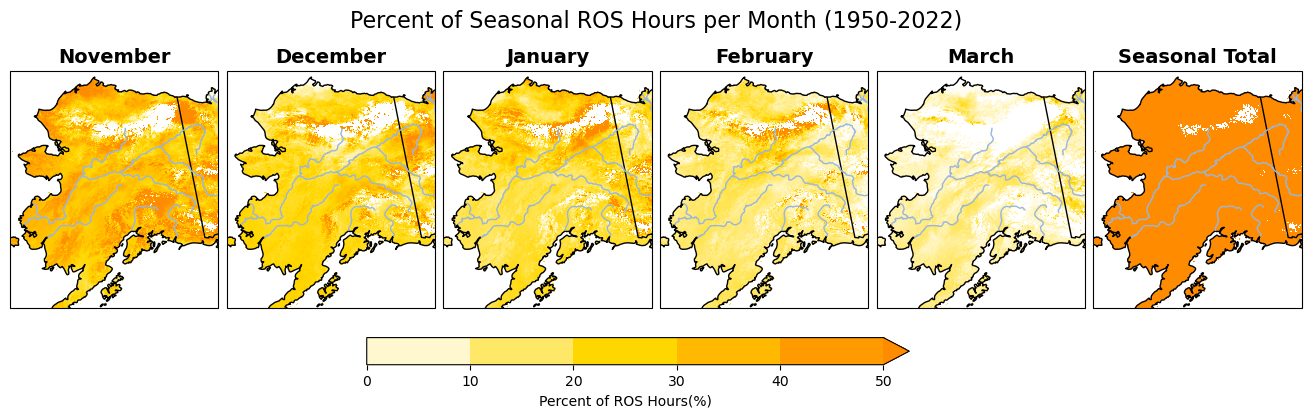

In [58]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('perc', ['white','gold','darkorange'])

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))
}

fig, axs = plt.subplots(
    nrows=1, ncols=6,
    figsize=(13, 4.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True
)
levels=np.arange(0, 60, 10)
vmin, vmax = 0, 50
datasets = [
    (nov_ros_pct, "November"),
    (dec_ros_pct, "December"),
    (jan_ros_pct, "January"),
    (feb_ros_pct, "February"),
    (mar_ros_pct, "March"),
    (total_pct, "Seasonal Total")
]

for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        shading='auto',
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title, fontsize=14, fontweight="bold")

    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08,
    extend='max', boundaries=levels
)
fig.suptitle('Percent of Seasonal ROS Hours per Month (1950-2022)', fontsize=16,y=0.9)
#fig.suptitle('Distribution of Seasonal Rain on Snow Hours per Month (1950-2022)', fontsize=16,y=0.9)
#fig.suptitle("Percent of ROS Hours (1950–2022)",fontsize=16, y=0.90)
cbar.set_label('Percent of ROS Hours(%)')
cbar.set_ticks(levels)  
fig.patch.set_alpha(0.0)
plt.show()

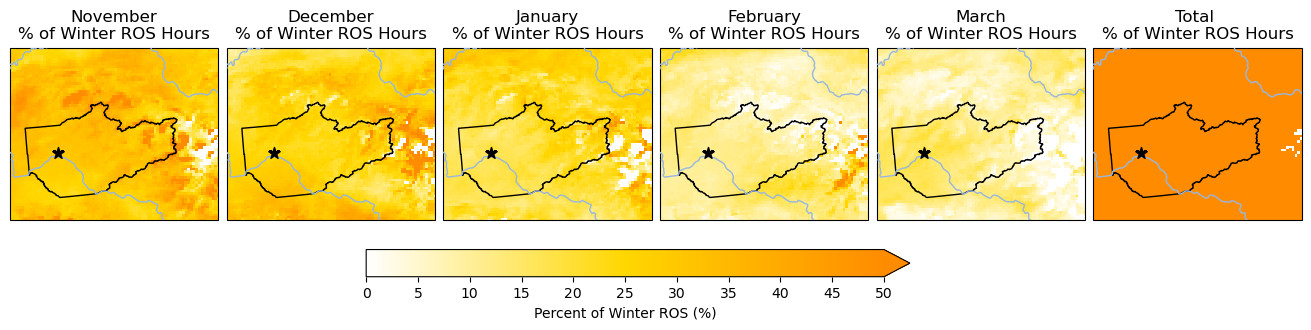

In [19]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('perc', ['white','gold','darkorange'])

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))
}

fig, axs = plt.subplots(
    nrows=1, ncols=6,
    figsize=(13, 4.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True
)

vmin, vmax = 0, 50  
datasets = [
    (nov_ros_pct, "November\n% of Winter ROS Hours"),
    (dec_ros_pct, "December\n% of Winter ROS Hours"),
    (jan_ros_pct, "January\n% of Winter ROS Hours"),
    (feb_ros_pct, "February\n% of Winter ROS Hours"),
    (mar_ros_pct, "March\n% of Winter ROS Hours"),
    (total_pct, "Total \n% of Winter ROS Hours")
]

for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        shading='auto',
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title)
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08,
    extend='max'
)

cbar.set_label('Percent of Winter ROS (%)')
cbar.set_ticks(np.arange(0, 55, 5))  
fig.patch.set_alpha(0.0)
plt.show()

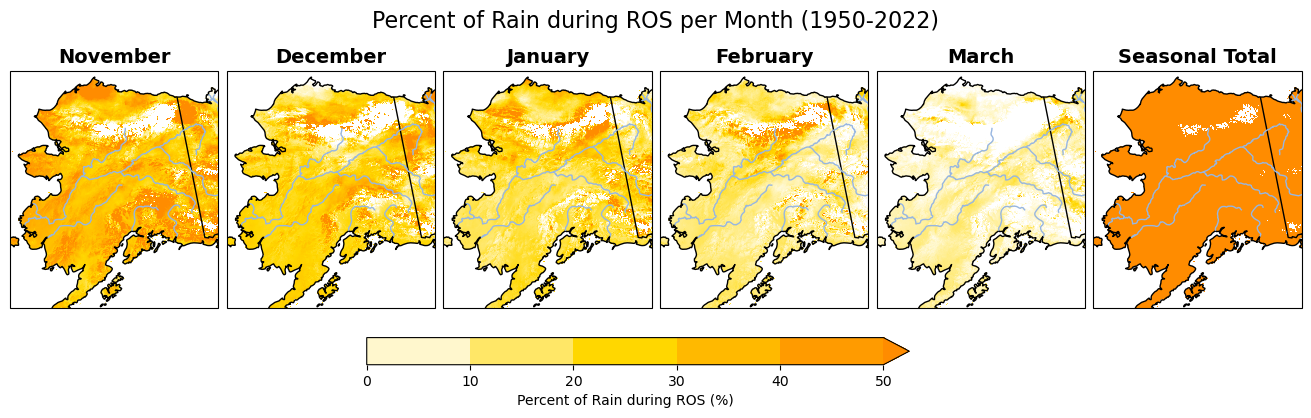

In [20]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('perc', ['white','gold','darkorange'])

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))
}

fig, axs = plt.subplots(
    nrows=1, ncols=6,
    figsize=(13, 4.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True
)
levels=np.arange(0, 60,10)
vmin, vmax = 0, 50  # <-- colorbar now 0-20%
datasets = [
    (nov_ros_rain_pct, "November"),
    (dec_ros_rain_pct, "December"),
    (jan_ros_rain_pct, "January"),
    (feb_ros_rain_pct, "February"),
    (mar_ros_rain_pct, "March"),
    (total_rain_pct, "Seasonal Total")
]

for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        shading='auto',
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')
fig.suptitle('Percent of Rain during ROS per Month (1950-2022)', fontsize=16,y=0.9)
#fig.suptitle('Distribution of Rain during ROS per Month (1950-2022)', fontsize=16,y=0.9)
#fig.suptitle("Percent of Rain during ROS (1950–2022)",fontsize=16, y=0.90)

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08, 
    extend='max',
    boundaries=levels
)

cbar.set_label('Percent of Rain during ROS (%)')
cbar.set_ticks(levels)  
fig.patch.set_alpha(0.0)
plt.show()


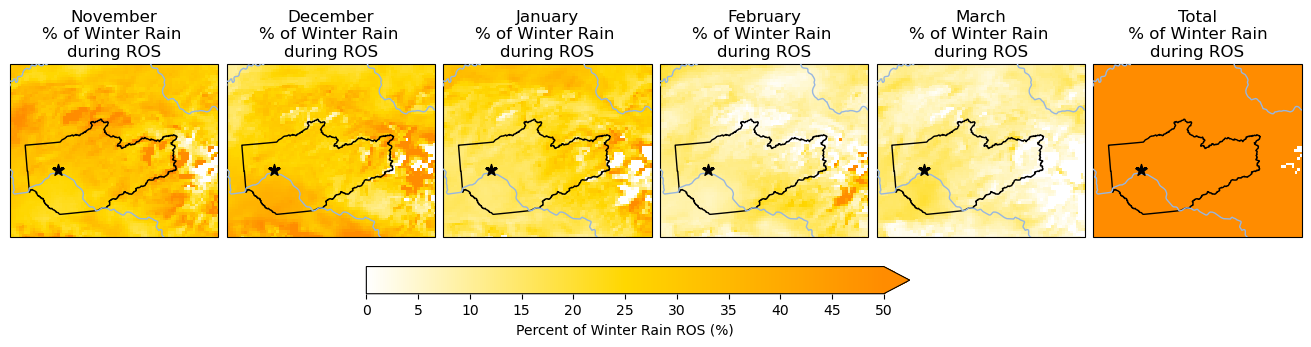

In [49]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('perc', ['white','gold','darkorange'])

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))
}

fig, axs = plt.subplots(
    nrows=1, ncols=6,
    figsize=(13, 4.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True
)

vmin, vmax = 0, 50  # <-- colorbar now 0-20%
datasets = [
    (nov_ros_rain_pct, "November\n% of Winter Rain \nduring ROS"),
    (dec_ros_rain_pct, "December\n% of Winter Rain \nduring ROS"),
    (jan_ros_rain_pct, "January\n% of Winter Rain \nduring ROS"),
    (feb_ros_rain_pct, "February\n% of Winter Rain \nduring ROS"),
    (mar_ros_rain_pct, "March\n% of Winter Rain \nduring ROS"),
    (total_rain_pct, "Total\n % of Winter Rain \nduring ROS")
]

for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        shading='auto',
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title)
    FNSB_boundary.plot(ax=ax, facecolor='none', edgecolor='black',linewidth=1,zorder=2,transform=ccrs.PlateCarree())
    ax.scatter(Fairbanks_lon, Fairbanks_lat, marker='*', color='k', s=75, zorder=9, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-149, -143, 64, 66], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08,extend='max'
)

cbar.set_label('Percent of Winter Rain ROS (%)')
cbar.set_ticks(np.arange(0, 55, 5))  
fig.patch.set_alpha(0.0)
plt.show()


Ratio of Percent of Hours over Percent of Rain Accumulation 
-

In [ ]:
nov_ros_tally_avg
nov_ros_rain_sum_avg
#nov_ros_pct/nov_ros_rain_pct

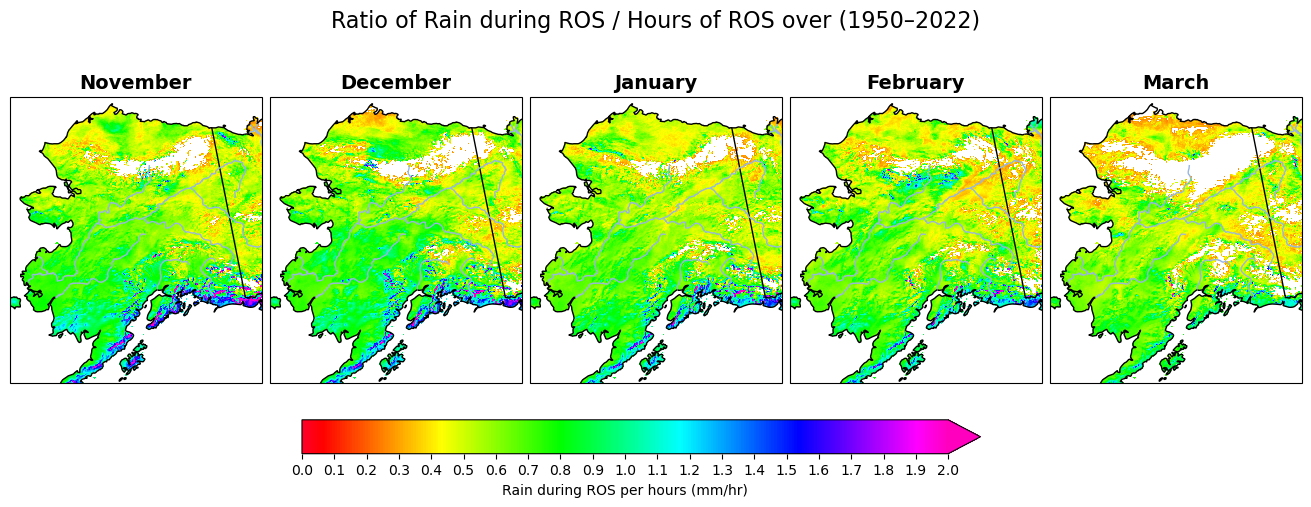

In [24]:
from matplotlib.colors import LinearSegmentedColormap

#cmap = LinearSegmentedColormap.from_list('perc', ['white','gold','darkorange'])
cmap='gist_rainbow'
AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))
}

fig, axs = plt.subplots(
    nrows=1, ncols=5,
    figsize=(13, 5.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True
)

vmin, vmax = 0, 2 
datasets = [
    (nov_ros_rain_sum_avg/nov_ros_tally_avg, "November"),
    (dec_ros_rain_sum_avg/dec_ros_tally_avg, "December"),
    (jan_ros_rain_sum_avg/jan_ros_tally_avg, "January"),
    (feb_ros_rain_sum_avg/feb_ros_tally_avg, "February"),
    (mar_ros_rain_sum_avg/mar_ros_tally_avg, "March"),
    #(total_rain_pct, "Seasonal Total")
]

for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        shading='auto',
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

fig.suptitle("Ratio of Rain during ROS / Hours of ROS over (1950–2022)",fontsize=16, y=0.90)

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08, 
    extend='max'
)

cbar.set_label('Rain during ROS per hours (mm/hr)')
cbar.set_ticks(np.arange(0, 2.1, 0.1))  
fig.patch.set_alpha(0.0)
plt.show()


Not during ROS
-

In [22]:
'''nov_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=11),axis=0)
dec_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=12),axis=0)
jan_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=1),axis=0)
feb_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=2),axis=0)
mar_ros_rain_sum_avg=np.mean(combined_ds['rain_ros_sum'].sel(month=3),axis=0)'''
nov_rain_sum_avg=np.mean(combined_ds['rain_sum'].sel(month=11),axis=0)
dec_rain_sum_avg=np.mean(combined_ds['rain_sum'].sel(month=12),axis=0)
jan_rain_sum_avg=np.mean(combined_ds['rain_sum'].sel(month=1),axis=0)
feb_rain_sum_avg=np.mean(combined_ds['rain_sum'].sel(month=2),axis=0)
mar_rain_sum_avg=np.mean(combined_ds['rain_sum'].sel(month=3),axis=0)

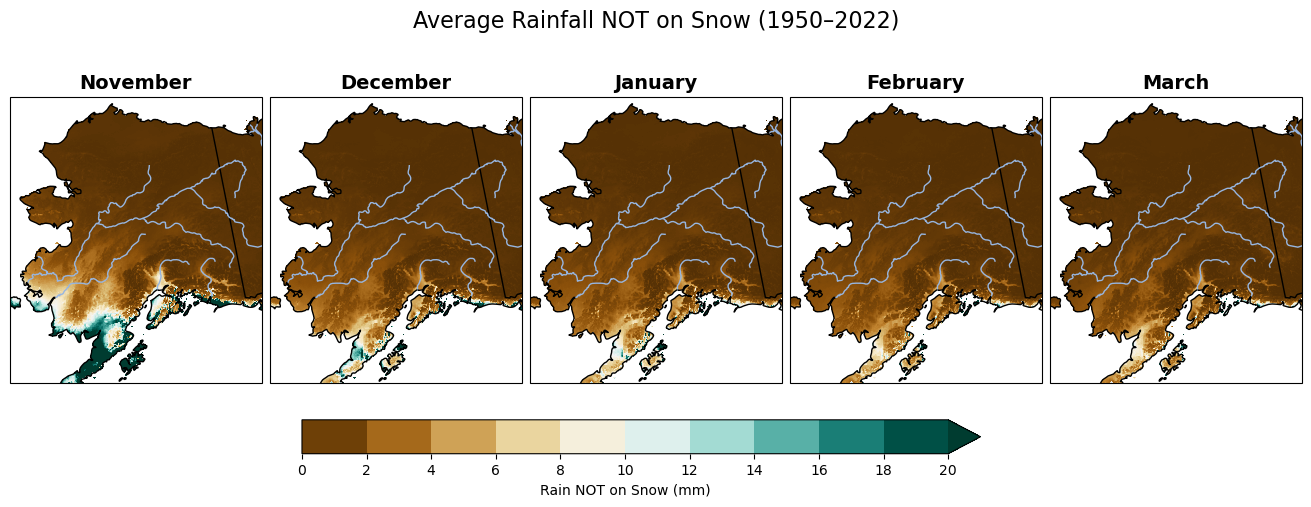

In [59]:
cmap = 'BrBG'
# LinearSegmentedColormap.from_list('perc', ['white','gold','darkorange'])

AK_ALBERS_SUBPLOT_KW = {
    'projection': ccrs.AlbersEqualArea(
        central_longitude=-154,
        central_latitude=50,
        standard_parallels=(55, 65))
}

fig, axs = plt.subplots(
    nrows=1, ncols=5,
    figsize=(13, 5.5),
    subplot_kw=AK_ALBERS_SUBPLOT_KW,
    constrained_layout=True
)
levels=np.arange(0, 22,2)
vmin, vmax = 0, 20
datasets = [
    (nov_rain_sum_avg-nov_ros_rain_sum_avg, "November"),
    (dec_rain_sum_avg-dec_ros_rain_sum_avg, "December"),
    (jan_rain_sum_avg-jan_ros_rain_sum_avg, "January"),
    (feb_rain_sum_avg-feb_ros_rain_sum_avg, "February"),
    (mar_rain_sum_avg-mar_ros_rain_sum_avg, "March"),
    #(total_rain_pct, "Seasonal Total")
]

for ax, (data, title) in zip(axs, datasets):
    pcm = ax.pcolormesh(
        lon, lat, data,
        cmap=cmap,
        vmin=vmin, vmax=vmax,  
        shading='auto',
        transform=ccrs.PlateCarree()
    )
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.add_feature(cfeature.BORDERS, zorder=8)
    ax.add_feature(cfeature.COASTLINE, zorder=8)
    ax.add_feature(cfeature.RIVERS, zorder=8)
    ax.set_extent([-165.3, -141, 55.8, 71.38], crs=ccrs.PlateCarree())
    ax.set_aspect('equal')

fig.suptitle("Average Rainfall NOT on Snow (1950–2022)",fontsize=16, y=0.90)

cbar = fig.colorbar(
    pcm,
    ax=axs,
    orientation='horizontal',
    fraction=0.08,
    pad=0.08, 
    extend='max',
    boundaries=levels
)

cbar.set_label('Rain NOT on Snow (mm)')
cbar.set_ticks(levels)  
fig.patch.set_alpha(0.0)
plt.show()


Histograms
-

In [65]:
combined_ds

<xarray.Dataset> Size: 6GB
Dimensions:              (season: 73, month: 5, south_north: 450,
                          west_east: 420, interp_level: 3, -: 1)
Coordinates:
  * season               (season) <U9 3kB '1950-1951' ... '2022-2023'
  * month                (month) int64 40B 11 12 1 2 3
    XLAT                 (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
    XLONG                (south_north, west_east) float32 756kB dask.array<chunksize=(450, 420), meta=np.ndarray>
  * interp_level         (interp_level) float64 24B 850.0 925.0 950.0
    month_name           (month) <U3 60B dask.array<chunksize=(5,), meta=np.ndarray>
    start_year           (season, -) int64 584B 1 1 1 1 1 1 1 ... 2 2 2 2 2 2 2
Dimensions without coordinates: south_north, west_east, -
Data variables: (12/13)
    ros_tally            (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ros_counts           (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ros_days_count       (season, month, south_north, west_east) float64 552MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_sum             (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_ros_sum         (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    rain_avg             (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    ...                   ...
    swe_avg              (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    swe_ros_avg          (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    T2_avg               (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    T2_ros_avg           (season, month, south_north, west_east) float32 276MB dask.array<chunksize=(1, 5, 450, 420), meta=np.ndarray>
    temp_levels_avg      (season, month, interp_level, south_north, west_east) float32 828MB dask.array<chunksize=(1, 3, 2, 450, 420), meta=np.ndarray>
    temp_levels_ros_avg  (season, month, interp_level, south_north, west_east) float32 828MB dask.array<chunksize=(1, 3, 2, 450, 420), meta=np.ndarray>

In [63]:
combined_ds['start_year'] = combined_ds['season'].str.split('-').str[0].astype(int)

start_year = combined_ds['season'].str.split('-').str[0].astype(int)

# Add 'start_year' as a coordinate to the Dataset
combined_ds.coords['start_year'] = start_year

# Now filter based on the 'start_year' coordinate
ds_1950_1979 = combined_ds.sel(start_year=slice(1950, 1979))
ds_1991_2020 = combined_ds.sel(start_year=slice(1991, 2020))

# Now calculate the monthly means for each period (example for 1950-1979)
nov_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=11).mean(dim='time')
dec_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=12).mean(dim='time')
jan_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=1).mean(dim='time')
feb_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=2).mean(dim='time')
mar_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=3).mean(dim='time')

# Similarly for the 1991-2020 period
nov_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=11).mean(dim='time')
dec_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=12).mean(dim='time')
jan_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=1).mean(dim='time')
feb_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=2).mean(dim='time')
mar_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=3).mean(dim='time')
#1950-1979 and 1991-2020

KeyError: "no index found for coordinate 'start_year'"

In [ ]:

ds_1950_1979 = combined_ds.sel(season=slice('1950-1951', '1979-1980'))
ds_1991_2020 = combined_ds.sel(season=slice('1991-1992', '2020-2021'))

# 1950-1979
nov_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=11).mean(dim='season')
dec_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=12).mean(dim='season')
jan_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=1).mean(dim='season')
feb_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=2).mean(dim='season')
mar_ros_1950_1979 = ds_1950_1979['ros_tally'].sel(month=3).mean(dim='season')

# 1991-2020
nov_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=11).mean(dim='season')
dec_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=12).mean(dim='season')
jan_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=1).mean(dim='season')
feb_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=2).mean(dim='season')
mar_ros_1991_2020 = ds_1991_2020['ros_tally'].sel(month=3).mean(dim='season')


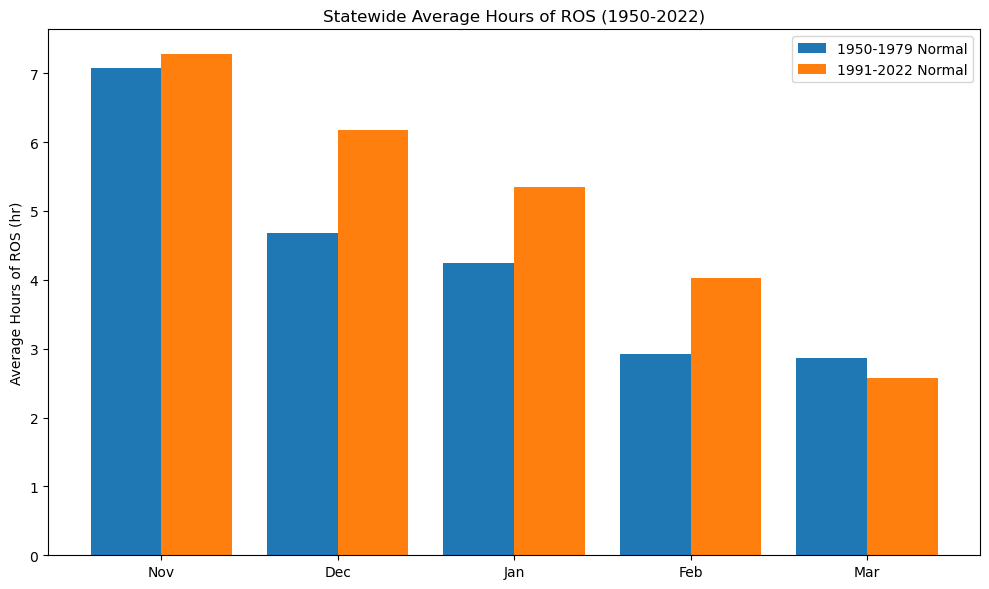

In [86]:
winter_months=[11,12,1,2,3]
month_labels = ['Nov','Dec','Jan','Feb','Mar']

average_monthly_1950 = [
    np.nanmean(nov_ros_1950_1979, axis=(0, 1)), 
    np.nanmean(dec_ros_1950_1979, axis=(0, 1)),
    np.nanmean(jan_ros_1950_1979, axis=(0, 1)),
    np.nanmean(feb_ros_1950_1979, axis=(0, 1)),
    np.nanmean(mar_ros_1950_1979, axis=(0, 1))]


average_monthly_1991 = [
    np.nanmean(nov_ros_1991_2020, axis=(0, 1)), 
    np.nanmean(dec_ros_1991_2020, axis=(0, 1)),
    np.nanmean(jan_ros_1991_2020, axis=(0, 1)),
    np.nanmean(feb_ros_1991_2020, axis=(0, 1)),
    np.nanmean(mar_ros_1991_2020, axis=(0, 1))]

x = np.arange(len(winter_months))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x-width/2, average_monthly_1950, width, color='#1f77b4', label='1950-1979 Normal')
ax.bar(x+width/2, average_monthly_1991, width, color='#ff7f0e', label='1991-2022 Normal')
ax.set_xticks(x)
ax.set_xticklabels(month_labels)
ax.set_ylabel('Average Hours of ROS (hr)')
ax.set_title('Statewide Average Hours of ROS (1950-2022)')
ax.legend()
plt.tight_layout()
plt.show()